In [54]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [55]:

bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/translation/21h7_s_z_2-4-6-8-10_720_30.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8]

In [56]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [57]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,2.612358
1,0.158055,2.670558
2,0.317188,2.649852
3,0.466575,2.591789
4,0.620741,2.477758
...,...,...
558,108.493724,5.352480
559,110.684389,2.997768
560,120.233429,2.284019
561,120.587693,3.154244


<AxesSubplot:xlabel='relative_time'>

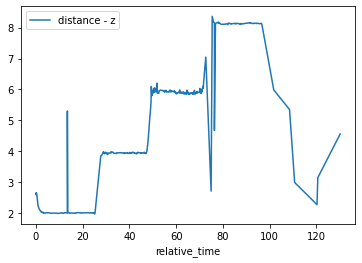

In [58]:
# initial graph
df.plot(x='relative_time', y=target)

In [59]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .05)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [60]:
# the amount of data points we are left with
len(x[peaks])

131

In [61]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

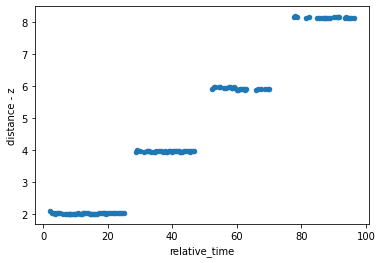

In [62]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [63]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)

In [64]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_filtered_by_targets)

,relative_time,distance - z,true_distance
14,2.061037,2.081701,2
19,2.791635,2.045093,2
22,3.243089,2.031700,2
24,3.532764,2.013795,2
29,4.424938,2.021551,2
31,4.722200,2.022223,2
35,5.317342,2.024206,2
40,6.084130,2.008262,2
46,6.984834,2.009219,2
49,7.422918,2.009703,2


In [65]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [66]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [67]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
14,2.061037,2.081701,2,-0.081701
19,2.791635,2.045093,2,-0.045093
180,28.636922,3.947117,4,0.052883
182,28.941769,3.994803,4,0.005197
329,52.282824,5.890118,6,0.109882
333,52.893028,5.967293,6,0.032707
469,77.783414,8.163994,8,-0.163994
471,78.084476,8.174847,8,-0.174847


In [68]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,45.0,-0.018691,0.012520,-0.081701,-0.022370,-0.018639,-0.009811,-0.001698
4,36.0,0.040371,0.013710,0.005197,0.030273,0.042195,0.049225,0.060473
6,27.0,0.076480,0.033061,0.017693,0.046142,0.082153,0.094699,0.132661
8,23.0,-0.138974,0.014435,-0.174847,-0.140900,-0.138003,-0.132735,-0.110978


In [69]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

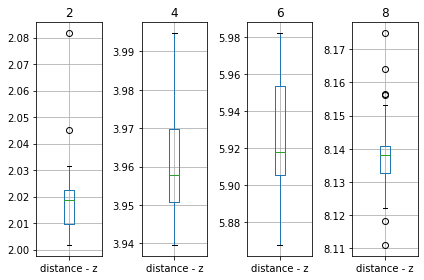

In [70]:
box_plotter(target)

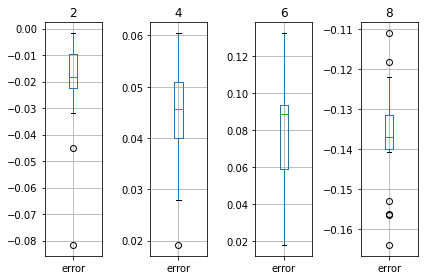

In [53]:
box_plotter('error')